In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
from scipy.stats import zscore
from scipy.signal import detrend
import copy
import sys
from scipy.integrate import simpson as simps
from nice.algorithms.connectivity import epochs_compute_wsmi
import mne
import warnings
warnings.filterwarnings("ignore")
from scipy.ndimage import gaussian_filter1d


def smooth_with_gaussian(data, sigma=3):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 

def preprocess(data):
    stds = np.std(data[:, :], axis=0)
    non_constant_cols = stds.astype(float) > 1e-6    #finds the time points where std is not 0
    const_cols = stds.astype(float) <= 1e-6    #finds the time points where std is 0

    z = np.zeros_like(data[:, :])   #creates an array of zeros with the same shape as the data
    z[:, non_constant_cols] = zscore(data[:, non_constant_cols], axis=0)  #in the columns where std is not 0, zscores the data
    z[:, const_cols] = np.mean(data[:, const_cols], axis=0)

 
    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z

# def preprocess(data):
#     data = detrend(data, axis=0)
#     epsilon = 1e-9
#     data = (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + epsilon)
    
#     return data

file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

wsmi_means = {f'dataset_{file_number}': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []} for file_number in file_numbers}
wsmi_stdevs = {f'dataset_{file_number}': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []} for file_number in file_numbers}

total_time = time.time()
for file_number in  file_numbers:
    file_total = time.time()
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")


    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]
    relevant = np.where(omitted ==0)[0]
    #left_input_SP (2032, 500, 160)
    #right_input_SP (2032, 500, 160)
    #attention_SP (2032, 500, 80)
    
    left_input_SP = data['SP'][0][0][relevant]
    right_input_SP = data['SP'][0][1][relevant]
    attention_SP = data['SP'][0][2][relevant]

    sigma = 2

    left_sm = smooth_with_gaussian(left_input_SP, sigma=sigma) 
    right_sm = smooth_with_gaussian(right_input_SP, sigma=sigma) 
    att_sm = smooth_with_gaussian(attention_SP, sigma=sigma) 

    num_trials, num_samples, num_neurons = left_input_SP.shape
    num_neurons_attention = 80

            
    for j in range(0, num_trials):
        for i in range(0, num_neurons):
            count_left = np.count_nonzero(left_input_SP[j, :, i] == 1)
            if count_left > 0:
                left_sm[j, :, i] /= count_left
            count_right = np.count_nonzero(right_input_SP[j, :, i] == 1)
            if count_right > 0:
                right_sm[j, :, i] /= count_right


        for i in range(0, num_neurons_attention):
            count_attention = np.count_nonzero(attention_SP[j, :, i] == 1)
            if count_attention > 0:
                att_sm[j, :, i] /= count_attention


    left_input_SP = np.sum(left_sm, axis=2)
    right_input_SP = np.sum(right_sm, axis=2)
    attention_SP = np.sum(att_sm, axis=2)

    #preprocess here now that we have traces of all of the relavant trials
    left_indices_agg = np.where((omitted ==0) & (attend_01 == 0))[0]  #indices of agg where left
    _, left_indices, _ = np.intersect1d(relevant, left_indices_agg, return_indices = True)   #indices for relevant processed data where attention left
    right_indices_agg = np.where((omitted ==0) & (attend_01 == 1))[0]
    _, right_indices, _ = np.intersect1d(relevant, right_indices_agg, return_indices = True)

    left_input_SP = preprocess(left_input_SP)
    right_input_SP = preprocess(right_input_SP)
    attention_SP = preprocess(attention_SP)

    #splitting left and right
    left_input_SP_attleft = left_input_SP[left_indices, 100:350]
    right_input_SP_attleft = right_input_SP[left_indices, 100:350]
    attention_SP_attleft = attention_SP[left_indices, 100:350]

    left_input_SP_attright = left_input_SP[right_indices, 100:350]
    right_input_SP_attright = right_input_SP[right_indices, 100:350]
    attention_SP_attright = attention_SP[right_indices, 100:350]


    #----------------------------------------------------------------
    
    n_times = left_input_SP_attleft.shape[1] ##=250
    print("n_samples", n_times)

    dt = 0.002
    sfreq = 1 / dt

    ch_names = ['left_input', 'right_input', 'attention_layer']
    ch_types = ['eeg', 'eeg', 'eeg']
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)


    #reshaping data for attention left
    raw_data_left = np.concatenate([
        left_input_SP_attleft, 
        right_input_SP_attleft, 
        attention_SP_attleft 
    ], axis=0)  # Concatenate along time axis

    print("raw_data_left shape =", raw_data_left.shape)  
    # Reshape into (n_channels, n_samples)
    raw_data_left = raw_data_left.reshape(3, -1)  
    print('raw data left reshaped =', raw_data_left.shape) 
    raw_left = mne.io.RawArray(raw_data_left, info)
    print("raw_data_left =", raw_left)
    

    #reshaping date for attention right 
    raw_data_right = np.concatenate([
        left_input_SP_attright,
        right_input_SP_attright,
        attention_SP_attright 
    ], axis=0)

    raw_data_right = raw_data_right.reshape(3, -1)
    raw_right = mne.io.RawArray(raw_data_right, info)


    #defininf event objects, arrays like [0,0,1], [250, 0, 1], [750, 0, 1] etc
    events_left = np.array([[i * n_times, 0, 1] for i in range(len(left_input_SP_attleft))])
    events_right = np.array([[i * n_times, 0, 1] for i in range(len(left_input_SP_attright))])

    
    print("events_left", events_left[:4])

    epochs_left = mne.Epochs(raw_left, events_left, event_id={'Trial': 1}, tmin=0, tmax =  0.498,  baseline=None, preload=True)
    epochs_right = mne.Epochs(raw_right, events_right, event_id={'Trial': 1}, tmin=0, tmax = 0.498, baseline=None, preload=True)
    print('----------------', (n_times - 1)/ sfreq)

    print("epochs_left", epochs_left)
    #epochs_left.plot(n_epochs=5, n_channels=3, scalings = 'auto', title="Attention Left")
    #plt.show()

    kernel = 3
    taus = [8, 16, 32, 64]  # in ms
    wsmi_results = {'left': {}, 'right': {}}

    for tau in taus:
        tau_samples = int(tau / (1000 / sfreq))
        print(f"tau_samples for {tau}: {tau_samples}")
        
        wsmi_left, _, _, _ = epochs_compute_wsmi(
            epochs_left, kernel=kernel, tau=tau_samples, backend='python', method_params={'bypass_csd': True}
        )
        wsmi_results['left'][tau] = wsmi_left
        #this containts the data for wsmi at a given tau given attending left. 

        wsmi_right, _, _, _ = epochs_compute_wsmi(
            epochs_right, kernel=kernel, tau=tau_samples, backend='python', method_params={'bypass_csd': True}
        )
        wsmi_results['right'][tau] = wsmi_right



    for tau in taus:
        wsmi_means[f'dataset_{file_number}']['left_attleft'].append(np.mean(wsmi_results['left'][tau][0, 2, :]))
        wsmi_means[f'dataset_{file_number}']['right_attleft'].append(np.mean(wsmi_results['left'][tau][1, 2, :]))
        wsmi_means[f'dataset_{file_number}']['left_attright'].append(np.mean(wsmi_results['right'][tau][0, 2, :]))
        wsmi_means[f'dataset_{file_number}']['right_attright'].append(np.mean(wsmi_results['right'][tau][1, 2, :]))

        wsmi_stdevs[f'dataset_{file_number}']['left_attleft'].append(np.std(wsmi_results['left'][tau][0, 2, :], ddof = 1))
        wsmi_stdevs[f'dataset_{file_number}']['right_attleft'].append(np.std(wsmi_results['left'][tau][1, 2, :], ddof = 1))
        wsmi_stdevs[f'dataset_{file_number}']['left_attright'].append(np.std(wsmi_results['right'][tau][0, 2, :], ddof = 1))
        wsmi_stdevs[f'dataset_{file_number}']['right_attright'].append(np.std(wsmi_results['right'][tau][1, 2, :], ddof = 1))

  
    del left_input_SP_attleft, right_input_SP_attleft, attention_SP_attleft, left_input_SP_attright, right_input_SP_attright, attention_SP_attright
    gc.collect()
    del(data)
    gc.collect()
    print(f'Dataset {file_number} complete in', time.time() - file_total)

print('total time elapsed =', time.time() - total_time)


Dataset 1 loaded in 15.47 seconds
n_samples 250
raw_data_left shape = (1485, 250)
raw data left reshaped = (3, 123750)
Creating RawArray with float64 data, n_channels=3, n_times=123750
    Range : 0 ... 123749 =      0.000 ...   247.498 secs
Ready.
raw_data_left = <RawArray | 3 x 123750 (247.5 s), ~2.8 MB, data loaded>
Creating RawArray with float64 data, n_channels=3, n_times=140500
    Range : 0 ... 140499 =      0.000 ...   280.998 secs
Ready.
events_left [[  0   0   1]
 [250   0   1]
 [500   0   1]
 [750   0   1]]
Not setting metadata
Not setting metadata
495 matching events found
No baseline correction applied
0 projection items activated
Loading data for 495 events and 250 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
562 matching events found
No baseline correction applied
0 projection items activated
Loading data for 562 events and 250 original time points ...
0 bad epochs dropped
---------------- 0.498
epochs_left <Epochs |  495 events

[np.float64(0.036656142321741976), np.float64(0.03427001505853414), np.float64(0.03398842857235132), np.float64(0.03401794659489621), np.float64(0.035874988674067194), np.float64(0.035880913490547464), np.float64(0.03706765424792823), np.float64(0.035144605480118066), np.float64(0.03508264594017548), np.float64(0.03401455618206574), np.float64(0.03476010087119118), np.float64(0.03368970447657152), np.float64(0.034343459745905), np.float64(0.03397433867055892), np.float64(0.035276800082399876), np.float64(0.03432752214713661)]
[np.float64(0.05266328380302638), np.float64(0.050597898327591276), np.float64(0.05077608338375056), np.float64(0.04864679378724461), np.float64(0.05212445998512974), np.float64(0.05053460383287171), np.float64(0.05287310005089255), np.float64(0.050606173934641466), np.float64(0.05101333894286059), np.float64(0.051312420682570664), np.float64(0.050201491497332454), np.float64(0.05095391728879947), np.float64(0.05075599302252462), np.float64(0.05187584232661713), n

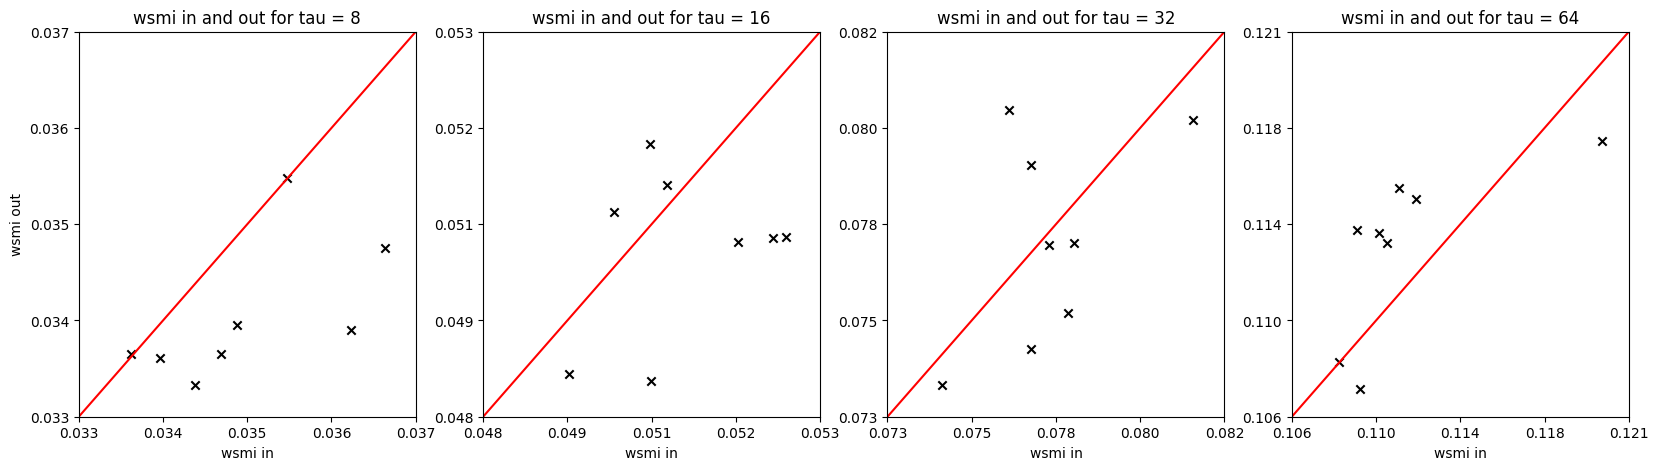

{'left': {8: array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.02688048, 0.00395743, 0.01286181, ..., 0.02892387,
         0.04726286, 0.06297701],
        [0.02767245, 0.02862033, 0.05446695, ..., 0.052579  ,
         0.05062398, 0.02630351]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.05674293, 0.07408219, 0.06271514, ..., 0.04885113,
         0.06841753, 0.01387045]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]]), 16: array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.04210

In [ ]:
taus = [0,1,2,3]
#want a single plot, where for each dataset, mean pearson in and mean pearson out are plotted with error bars
wsmi_in = {f'{tau}': [] for tau in taus}
wsmi_out = {f'{tau}': [] for tau in taus}
errors_in = {f'{tau}': [] for tau in taus}
errors_out = {f'{tau}': [] for tau in taus}


for file_number in file_numbers:
    values = []
    errors = []
    for tau in taus:
        for condition in ['left_attleft', 'right_attright']:
            values.append(wsmi_means[f'dataset_{file_number}'][condition][tau])
            errors.append(wsmi_stdevs[f'dataset_{file_number}'][condition][tau])
        wsmi_in[f'{tau}'].append(np.mean(values))
        errors_in[f'{tau}'].append(np.mean(errors))


    values = []
    errors = []
    for tau in taus:
        for condition in ['left_attright', 'right_attleft']:
            values.append(wsmi_means[f'dataset_{file_number}'][condition][tau])
            errors.append(wsmi_stdevs[f'dataset_{file_number}'][condition][tau])
        wsmi_out[f'{tau}'].append(np.mean(values))
        errors_out[f'{tau}'].append(np.mean(errors))

max_values = {f'{tau}': [] for tau in taus}
min_values = {f'{tau}': [] for tau in taus}

idx = np.arange(len(file_numbers))
for tau in taus:
    values = []
    for f in idx:
        values.append(wsmi_in[f'{tau}'][f])
        values.append(wsmi_out[f'{tau}'][f])
    print(values)
    max_values[f'{tau}'].append(max(values))
    min_values[f'{tau}'].append(min(values))

tau_values = [8,16,32,64]
N_ticks = 5  


fig, axs = plt.subplots(1,4, figsize=(20, 5))
for tau, i in zip(taus, range(5)):
    axs[i].scatter(wsmi_in[f'{tau}'], wsmi_out[f'{tau}'], marker = 'x', color='k')
    axs[i].plot([0, 1], [0, 1], transform=axs[i].transAxes, color='r')

    local_min = min_values[f'{tau}'][0] * 0.99
    local_max = max_values[f'{tau}'][0] * 1.01

    tick_values = np.linspace(local_min, local_max, N_ticks)
    axs[i].set_xlim(local_min, local_max)
    axs[i].set_ylim(local_min, local_max)
    axs[i].set_xticks(tick_values)
    axs[i].set_yticks(tick_values)
    axs[i].set_xticklabels([f"{tick:.3f}" for tick in tick_values])
    axs[i].set_yticklabels([f"{tick:.3f}" for tick in tick_values])

    axs[i].set_xlabel('wsmi in')
    axs[0].set_ylabel('wsmi out')
    axs[i].set_title(f'wsmi in and out for tau = {tau_values[tau]}')
plt.show()


print(wsmi_results)